# Defining the functions

In [2]:
import qutip as qt
import numpy as np
import numpy.linalg as alg

In [3]:
def operator_nlevel_trunc(nlevels, op, states, method="qutip"):
    if method.lower() == "qutip":
        transformed = op.transform(states).tidyup()
        return qt.Qobj(
            arg=transformed.full()[:nlevels, :nlevels],
            dims=[[nlevels], [nlevels]],
        )

    elif method.lower() == "numpy":
        U = states[:, :nlevels]
        return np.dot(U.conj().T, np.dot(op, U))

    else:
        raise ValueError("Method not recognized")

In [4]:
def hamiltonian_qt(
    ECT, ECR, ECoup, EJ, EL, transmon_trunc=31, resonator_trunc=40, n_levels_transmon=2
):
    ## Transmon Hamiltonian
    charge = qt.charge(transmon_trunc // 2, -transmon_trunc // 2)
    cos_phi = qt.tunneling(2 * transmon_trunc // 2 + 1)
    HT = 4 * ECT * charge * charge - EJ / 2 * cos_phi

    _, Evecs = HT.eigenstates()

    HT_ndim = operator_nlevel_trunc(n_levels_transmon, HT, Evecs)
    charge_ndim = operator_nlevel_trunc(n_levels_transmon, charge, Evecs)

    ## Resonator Hamiltonian
    creation = qt.create(resonator_trunc)
    destruction = qt.destroy(resonator_trunc)

    HR = np.sqrt(8 * ECR * EL) * (creation * destruction + 1 / 2)

    ## Coupling Hamiltonian
    phizpf = ((2 * ECR) / EL) ** (1 / 4)
    n_R = (destruction - creation) / (2j * phizpf)

    HC = -4 * ECoup * qt.tensor(charge_ndim, n_R)

    ## Final Hamiltonian :
    return (
        qt.tensor(HT_ndim, qt.qeye(resonator_trunc))
        + qt.tensor(qt.qeye(n_levels_transmon), HR)
        + HC
    )

In [5]:
def find_state_match_index(Product_state_ind, True_evecs, resonator_trunc):
    product_state = qt.tensor(
        qt.basis(2, Product_state_ind[0]),
        qt.basis(resonator_trunc, Product_state_ind[1]),
    )

    best_ind = 0
    best_val = 0

    i = 0

    for i, psi in enumerate(True_evecs):
        scalar_prod = abs(psi.overlap(product_state))

        if best_val < scalar_prod:
            best_ind = i
            best_val = scalar_prod

        i += 1

    return best_ind

The equation :

$$
H_{approx} \approx \hbar(\omega_r + \chi\hat\sigma_z)\hat a^{\dagger} \hat a + \frac {\hbar \omega_q} 2 \hat\sigma_z
$$

In [6]:
def find_chi(ECT, ECR, ECoup, EJ, EL, transmon_trunc=31, resonator_trunc=40):
    H = hamiltonian_qt(ECT, ECR, ECoup, EJ, EL, transmon_trunc, resonator_trunc)

    Evals, Evecs = H.eigenstates(sparse=False)

    omegaq = (
        Evals[find_state_match_index([1, 0], Evecs, resonator_trunc)]
        - Evals[find_state_match_index([0, 0], Evecs, resonator_trunc)]
    )
    omegaq_plus_2chi = (
        Evals[find_state_match_index([1, 1], Evecs, resonator_trunc)]
        - Evals[find_state_match_index([0, 1], Evecs, resonator_trunc)]
    )

    return 1 / 2 * (omegaq_plus_2chi - omegaq)

Remember that we had : 
$$E_{coupling} := e^2 \frac{C_C}{C_T C_R}$$
And 
$$g = -4E_{coupling}$$ $$\Delta = \omega_q-\omega_r$$

# Plotting the results

We would like to plot $\chi$ as a function of $\frac g {\Delta}$. We will have g fixed here and change $\Delta$ through $\omega_r$, or rather through $E_L$

In [7]:
import matplotlib.pyplot as plt

The analytical expression of this $\chi$ is :
$$
\chi = - \frac {g^2} {\Delta}
$$

Where :
- $g$ is the coupling strength
- $\Delta$ the qubit-resonator detuning

In [8]:
def chi_analytical(Delta, g):
    return -(g**2) / (Delta)

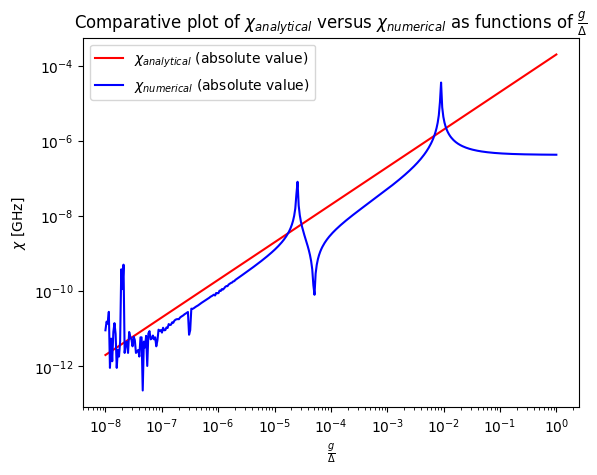

In [9]:
ECT = 0.5
ECR = 0.5
EJ = 5
ECoup = 5e-5

g = 4 * ECoup

omega_q = np.sqrt(8 * EJ * ECT) - ECT

G_over_delta = np.logspace(-8, 0, 400)

Chi_numerical = []
Chi_analytical = []

for g_over_delta in G_over_delta:
    Delta = g / g_over_delta
    omega_r = omega_q - Delta
    EL = omega_r**2 / (8 * ECR)

    Chi_numerical.append(find_chi(ECT, ECR, ECoup, EJ, EL, resonator_trunc=20))

    Chi_analytical.append(chi_analytical(Delta, g))

fig, ax = plt.subplots()

ax.plot(G_over_delta, np.abs(Chi_analytical), c="r")
ax.plot(G_over_delta, np.abs(Chi_numerical), c="b")
ax.legend(
    [r"$\chi_{analytical}$ (absolute value)", r"$\chi_{numerical}$ (absolute value)"]
)
ax.set(
    xlabel=r"$\frac {g} {\Delta}$",
    ylabel=r"$\chi$ [GHz]",
    title=r"Comparative plot of $\chi_{analytical}$ versus $\chi_{numerical}$ as functions of $\frac {g} {\Delta}$",
    xscale="log",
    yscale="log",
)

plt.show()

# What about using Lanczos ?
An imporvement we could make is use Lanczos' algorithm, which will provide a good approximation for the first few eigenvalues, say 10 here, while being much faster at diagonalizing our Hamiltonian. Let's put this to the test :

In [10]:
def find_chi_lanczos(ECT, ECR, ECoup, EJ, EL, transmon_trunc=31, resonator_trunc=40):
    H = hamiltonian_qt(ECT, ECR, ECoup, EJ, EL, transmon_trunc, resonator_trunc)

    Evals, Evecs = H.eigenstates(
        sparse=True, eigvals=10
    )  ##The one change we made is tell the solver that our matrix is sparse, meaning it will use Lanczos.

    omegaq = (
        Evals[find_state_match_index([1, 0], Evecs, resonator_trunc)]
        - Evals[find_state_match_index([0, 0], Evecs, resonator_trunc)]
    )
    omegaq_plus_2chi = (
        Evals[find_state_match_index([1, 1], Evecs, resonator_trunc)]
        - Evals[find_state_match_index([0, 1], Evecs, resonator_trunc)]
    )

    return 1 / 2 * (omegaq_plus_2chi - omegaq)

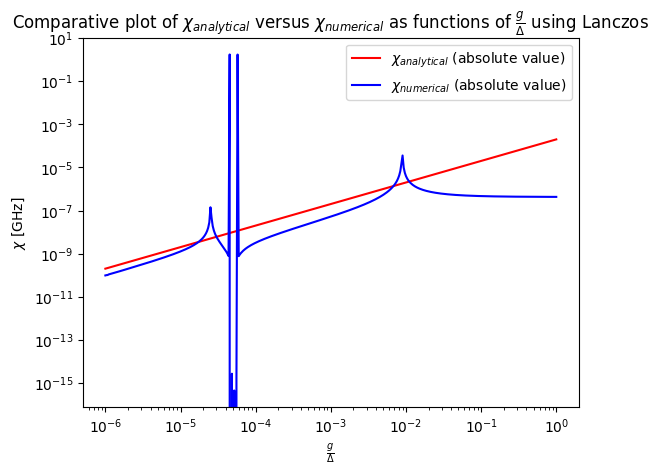

In [11]:
ECT = 0.5
ECR = 0.5
EJ = 5
ECoup = 5e-5

g = 4 * ECoup

omega_q = np.sqrt(8 * EJ * ECT) - ECT

G_over_delta = np.logspace(-6, 0, 400)

Chi_numerical = []
Chi_analytical = []

for g_over_delta in G_over_delta:
    Delta = g / g_over_delta
    omega_r = omega_q - Delta
    EL = omega_r**2 / (8 * ECR)

    Chi_numerical.append(find_chi_lanczos(ECT, ECR, ECoup, EJ, EL, resonator_trunc=20))

    Chi_analytical.append(chi_analytical(Delta, g))

fig, ax = plt.subplots()

ax.plot(G_over_delta, np.abs(Chi_analytical), c="r")
ax.plot(G_over_delta, np.abs(Chi_numerical), c="b")
ax.legend(
    [r"$\chi_{analytical}$ (absolute value)", r"$\chi_{numerical}$ (absolute value)"]
)
ax.set(
    xlabel=r"$\frac {g} {\Delta}$",
    ylabel=r"$\chi$ [GHz]",
    title=r"Comparative plot of $\chi_{analytical}$ versus $\chi_{numerical}$ as functions of $\frac {g} {\Delta}$ using Lanczos",
    xscale="log",
    yscale="log",
)

plt.show()

We see that the algorithm finds almost the same values, besides from a precise part of the graph where it gets really wierd. We don't see much difference between execution times, so we will compare them with much higher dimensions to make this feature noticable.

In [12]:
import time
import scipy.sparse.linalg as sl

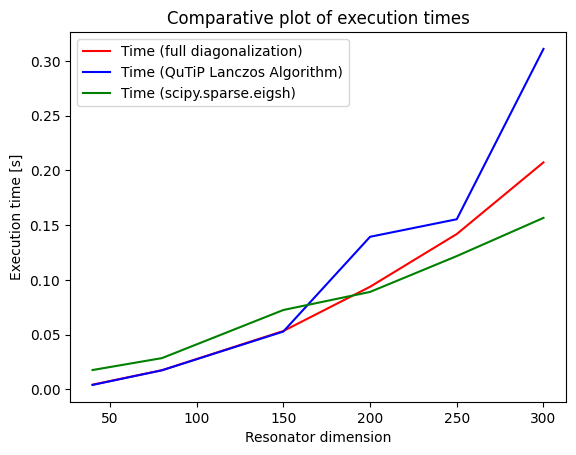

In [13]:
ECT = 0.5
ECR = 0.5
EJ = 5
ECoup = 5e-5
g_over_delta = 1e-3

g = 4 * ECoup

omega_q = np.sqrt(8 * EJ * ECT) - ECT

Resonator_dims = [40, 80, 150, 200, 250, 300]

Times_full = []
Times_lanczos_qt = []
Times_lanczos_np = []

Delta = g / g_over_delta
omega_r = omega_q - Delta
EL = omega_r**2 / (8 * ECR)

for rdim in Resonator_dims:
    H = hamiltonian_qt(ECT, ECR, ECoup, EJ, EL, resonator_trunc=rdim)
    H_np = H.full()

    start = time.time()
    # Do it 20 times
    for i in range(20):
        H.eigenstates(sparse=False)
    end = time.time()

    Times_full.append((end - start) / 20)

    start = time.time()
    for i in range(20):
        H.eigenstates(sparse=True)
    end = time.time()

    Times_lanczos_qt.append((end - start) / 20)

    start = time.time()
    for i in range(20):
        sl.eigsh(A=H_np, k=4)
    end = time.time()

    Times_lanczos_np.append((end - start) / 20)

fig, ax = plt.subplots()

ax.plot(Resonator_dims, Times_full, c="r")
ax.plot(Resonator_dims, Times_lanczos_qt, c="b")
ax.plot(Resonator_dims, Times_lanczos_np, c="g")
ax.legend(
    [
        r"Time (full diagonalization)",
        r"Time (QuTiP Lanczos Algorithm)",
        r"Time (scipy.sparse.eigsh)",
    ]
)
ax.set(
    xlabel=r"Resonator dimension",
    ylabel=r"Execution time [s]",
    title=r"Comparative plot of execution times",
)

plt.show()

# Another Method : Expected values of $\hat N$, and then sorting by energy level.

### The QuTiP Version

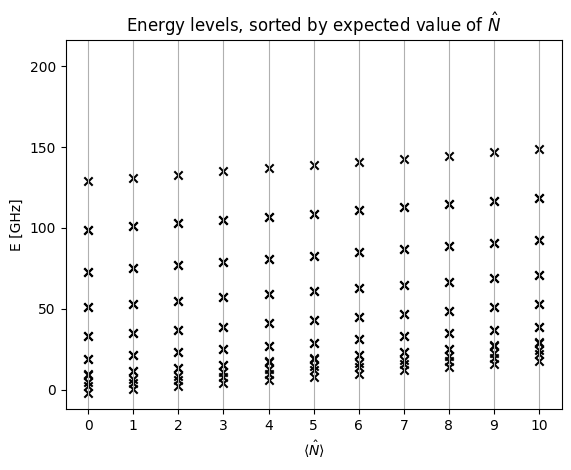

In [14]:
ECT = 0.5
ECR = 0.5
EJ = 5
ECoup = 5e-5
g_over_delta = 1e-4
transmon_trunc = 51
resonator_trunc = 40
n_levels_transmon = 16

g = 4 * ECoup

omega_q = np.sqrt(8 * EJ * ECT) - ECT
Delta = g / g_over_delta
omega_r = omega_q - Delta
EL = omega_r**2 / (8 * ECR)

H = hamiltonian_qt(
    ECT,
    ECR,
    ECoup,
    EJ,
    EL,
    transmon_trunc,
    resonator_trunc,
    n_levels_transmon=n_levels_transmon,
)
Evals, Evecs = H.eigenstates()


@np.vectorize
def expect_list(op, psi):
    return qt.expect(op, psi)


N = qt.num(resonator_trunc)

Expected_N = expect_list(qt.tensor(qt.qeye(n_levels_transmon), N), Evecs)

fig, ax = plt.subplots()

custom_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
custom_tick_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

ax.scatter(Expected_N, Evals, marker="x", c="black")
ax.set(
    xlim=[-0.5, 10.5],
    title=r"Energy levels, sorted by expected value of $\hat N$",
    xlabel=r"$\langle \hat N \rangle$",
    ylabel=r"E [GHz]",
    xticks=custom_ticks,
    xticklabels=custom_tick_labels,
)
plt.grid(axis="x")
plt.show()

### The Numpy version :

First we start by reimplementing the numpy hamiltonian :

In [15]:
def hamiltonian_np(
    ECT, ECR, ECoup, EJ, EL, transmon_trunc=41, resonator_trunc=40, n_levels_transmon=2
):
    ## Transmon Hamiltonian

    dim_transmon = 2 * transmon_trunc // 2 + 1
    charge = np.zeros((dim_transmon, dim_transmon))
    cos_phi = np.zeros((dim_transmon, dim_transmon))

    for i in range(dim_transmon - 1):
        cos_phi[i, i + 1] = 1
        cos_phi[i + 1, i] = 1
        charge[i, i] = i - dim_transmon // 2

    charge[-1, -1] = dim_transmon // 2

    HT = 4 * ECT * charge**2 - EJ / 2 * cos_phi

    _, Evecs = alg.eigh(HT)

    HT_ndim = operator_nlevel_trunc(n_levels_transmon, HT, Evecs, method="numpy")
    charge_ndim = operator_nlevel_trunc(
        n_levels_transmon, charge, Evecs, method="numpy"
    )

    ## Resonator Hamiltonian

    destruction = np.zeros((resonator_trunc, resonator_trunc))

    for n in range(1, resonator_trunc):
        destruction[n - 1, n] = np.sqrt(n)

    creation = destruction.T

    HR = np.sqrt(8 * ECR * EL) * (
        np.dot(creation, destruction) + np.eye(resonator_trunc) * (1 / 2)
    )

    ## Coupling Hamiltonian

    phizpf = ((2 * ECR) / EL) ** (1 / 4)
    n_R = (destruction - creation) / (2j * phizpf)

    HC = -4 * ECoup * np.kron(charge_ndim, n_R)

    ## Final Hamiltonian
    return (
        np.kron(HT_ndim, np.eye(resonator_trunc))
        + np.kron(np.eye(n_levels_transmon), HR)
        + HC
    ), (HT_ndim, HR, charge_ndim, n_R)

c:\miniconda\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\miniconda\Lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


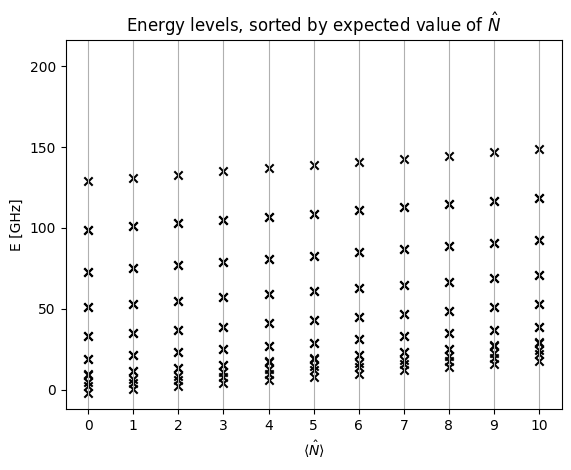

In [16]:
ECT = 0.5
ECR = 0.5
EJ = 5
ECoup = 5e-5
g_over_delta = 1e-4
transmon_trunc = 51
resonator_trunc = 40
n_levels_transmon = 16

g = 4 * ECoup

omega_q = np.sqrt(8 * EJ * ECT) - ECT
Delta = g / g_over_delta
omega_r = omega_q - Delta
EL = omega_r**2 / (8 * ECR)

H, _ = hamiltonian_np(
    ECT,
    ECR,
    ECoup,
    EJ,
    EL,
    transmon_trunc,
    resonator_trunc,
    n_levels_transmon=n_levels_transmon,
)
Evals, Evecs = alg.eigh(H)


@np.vectorize
def expect_list(op, psi):
    return np.dot(psi.conj().T, np.dot(op, psi))


N = np.zeros((resonator_trunc, resonator_trunc))
for i in range(resonator_trunc):
    N[i, i] = i

op = np.kron(np.eye(n_levels_transmon), N)
Expected_N = np.diag(np.dot(Evecs.conj().T, np.dot(op, Evecs)))

fig, ax = plt.subplots()

custom_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
custom_tick_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

ax.scatter(Expected_N, Evals, marker="x", c="black")
ax.set(
    xlim=[-0.5, 10.5],
    title=r"Energy levels, sorted by expected value of $\hat N$",
    xlabel=r"$\langle \hat N \rangle$",
    ylabel=r"E [GHz]",
    xticks=custom_ticks,
    xticklabels=custom_tick_labels,
)
plt.grid(axis="x")
plt.show()

In [17]:
def apply_tensor_product(axes: int, H: np.ndarray, V: np.ndarray) -> np.ndarray:
    """
    Apply sparse matrix H to the specified axis of tensor V

    Args:
        axes: which axis to apply the operator to (0, 1, 2, or 3)
        H: sparse matrix operator
        V: multi-dimensional array

    Returns:
        Result of applying H to axis 'axes' of V

    The following implementation works 3-4 times faster on smaller matrices:
    - np.einsum("ij,jabc->iabc", H, V)
    - np.dot between N-D and M-D matrices
    - reshaping and applying matrix multiplication
    However, all of them are impossible to use with sparse matrices.
    For larger matrices the implementation below for sparse matrix is faster
    by 1-1.5 times compare to implementations above on dense matrices

    """
    selected_axes_len = V.shape[axes]
    V = np.swapaxes(V, axes, 0)
    shape = V.shape
    V = np.reshape(V, (selected_axes_len, -1))
    # Apply sparse matrix multiplication
    result = H @ V
    result = np.reshape(result, shape)
    return np.swapaxes(result, 0, axes)

$$
\begin{align}
\hat H = & \ \bigg[4E_{C_T}{\hat n_T}^2 - E_J \cos(\hat\varphi_T)\bigg] \otimes {\mathbb{I}} \\
&+ \mathbb{I} \otimes \left(\hbar \omega (\hat a^{\dagger} \hat a) + \frac 1 2\right) \\ 
& -4E_{coupling} \ \hat n_T \otimes \left(\frac{\hat a - \hat a^{\dagger}} {2i\varphi_{ZPF}}\right) \\
& = \ H_T \otimes {\mathbb{I}} \\
&+ \mathbb{I} \otimes  H_R \\ 
& -4E_{coupling}\hat n_T \otimes \hat n_R
\end{align}
$$

In [18]:
def evaluate_hamiltonian(V, HT, HR, nT, nR, n_levels_transmon, resonator_trunc):
    Psi = np.reshape(V, (n_levels_transmon,resonator_trunc))
    return np.reshape(apply_tensor_product(0, HT, Psi) + apply_tensor_product(1, HR, Psi) - 4 * ECoup *apply_tensor_product(0, nT, apply_tensor_product(1, nR, Psi)), n_levels_transmon*resonator_trunc)

In [19]:
import scipy.sparse.linalg as sp_alg
import matplotlib.lines as mlines

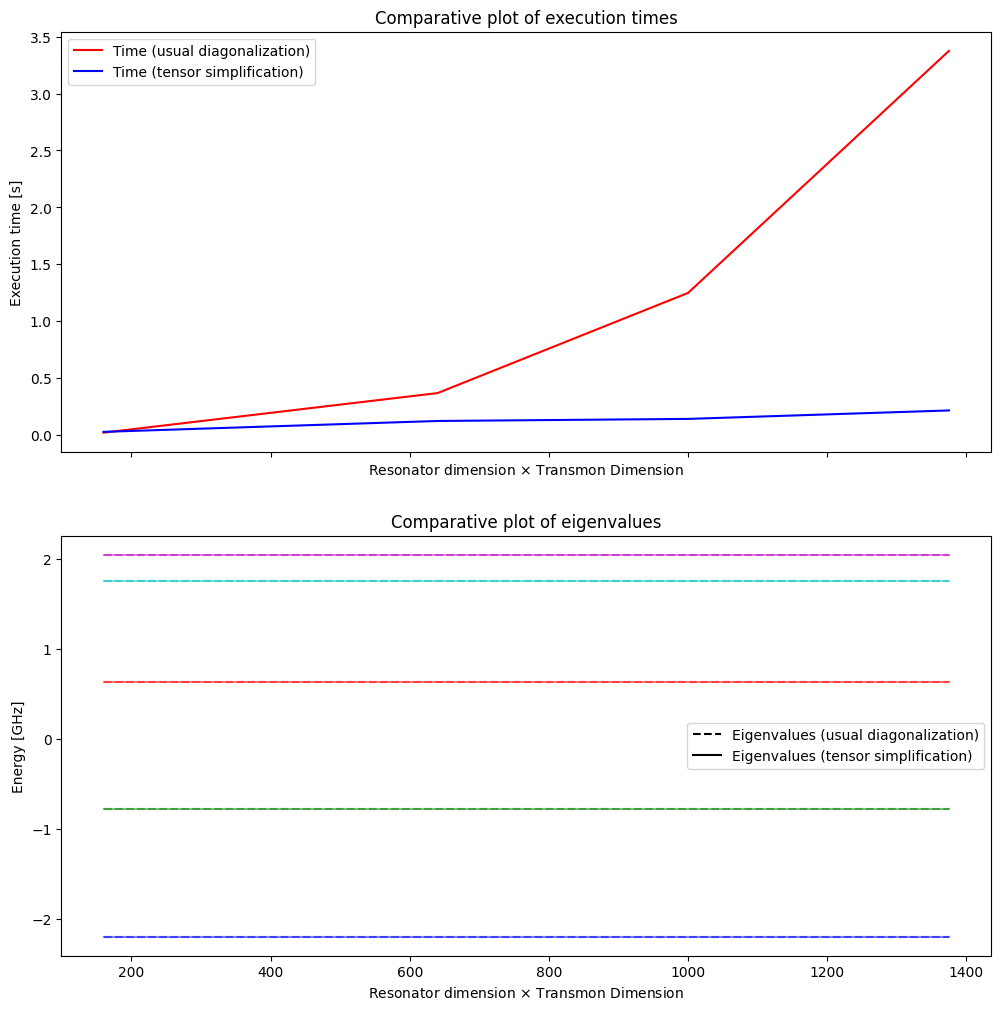

In [21]:
ECT = 0.5
ECR = 0.5
EJ = 5
ECoup = 5e-5
EL = 0.5

Dims = [(8,20), (16,40) , (20, 50), (25,55)]#, (25,60)]
Ticks = [a*b for (a,b) in Dims]


Times_normal = []
Times_tensor_network = []
Vals_normal = np.empty((5,len(Dims))) # Keep the 5 first eigenvalues
Vals_tensor_network = np.empty((5,len(Dims)))

for iter, (tdim,rdim) in enumerate(Dims):

    H, (HT, HR, nT, nR) = hamiltonian_np(ECT, ECR, ECoup, EJ, EL, resonator_trunc=rdim, n_levels_transmon= tdim)

    total_time = 0
    # Do it 20 times
    for i in range(20):
        start = time.time()
        vals, _ = alg.eigh(H)
        end = time.time()
        total_time += end - start
        
        vals.sort()
        Vals_normal[:, iter] += vals[:5]


    Times_normal.append(total_time / 20)

    total_time = 0

    Op = sp_alg.LinearOperator(shape=(rdim*tdim, rdim*tdim), matvec = lambda V : evaluate_hamiltonian(V, HT, HR, nT, nR, tdim, rdim), dtype=np.complex128)
    for i in range(20):
        start = time.time()
        vals, _ = sp_alg.eigsh(Op, k = 7, which = 'SA')
        end = time.time()
        total_time += end - start
        
        vals.sort()
        Vals_tensor_network[:, iter] += vals[:5]

    Times_tensor_network.append(total_time / 20)

Vals_normal = Vals_normal/20
Vals_tensor_network = Vals_tensor_network/20


fig, axs = plt.subplots(2,figsize=(12, 12), sharex=True)
# ========== Comparing Times ===========
axs[0].plot(Ticks, Times_normal, c="r")
axs[0].plot(Ticks, Times_tensor_network, c="b")
axs[0].legend(
    [
        r"Time (usual diagonalization)",
        r"Time (tensor simplification)",
    ]
)
axs[0].set(
    xlabel=r"Resonator dimension $\times$ Transmon Dimension",
    ylabel=r"Execution time [s]",
    title=r"Comparative plot of execution times",
)


# ========== Comparing Eigenvalues =========
Colors = ["b", "g", "r", "c", "m"]
for i in range(5):
    axs[1].plot(Ticks, Vals_normal[i, :], linestyle="--", c=Colors[i], alpha=0.5)
    axs[1].plot(Ticks, Vals_tensor_network[i, :], linestyle="-", c=Colors[i], alpha=0.5)
    
axs[1].legend(
    handles=[
        mlines.Line2D([], [], color="black", linestyle="--", label=r"Eigenvalues (usual diagonalization)"),
        mlines.Line2D([], [], color="black", linestyle="-", label=r"Eigenvalues (tensor simplification)"),
    ]
)

axs[1].set(
    xlabel=r"Resonator dimension $\times$ Transmon Dimension",
    ylabel=r"Energy [GHz]",
    title=r"Comparative plot of eigenvalues",
)

plt.show()